In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.data_util import load_augmented_example
from src.evaluation import DAP_SAP_MAP_kde, hist_AP, plot_SAP_MAP
from src.helping import find_pig_indices
import tensorflow as tf

from sklearn.model_selection import train_test_split
import glob
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
tf.random.set_seed(42)

2024-12-19 13:57:50.575313: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-19 13:57:51.187912: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load training and validation data

![](images/hist_pig_samples_aug_v2.png)

The model is tuned using the augmented prepared data (hatched orange/blue) and the prepared original data (blue) and is validated using the validation data (green).

In [2]:
pigs = ["P_{0:02d}_PulHyp".format(i) for i in range(1, 11)]
print(pigs)

load_path = "/data/PulHypStudie_Check_npz_v5_SNR30/"

['P_01_PulHyp', 'P_02_PulHyp', 'P_03_PulHyp', 'P_04_PulHyp', 'P_05_PulHyp', 'P_06_PulHyp', 'P_07_PulHyp', 'P_08_PulHyp', 'P_09_PulHyp', 'P_10_PulHyp']


In [3]:
X_train, y_train, clrs_pig_train = load_augmented_example(
    load_path, pigs, sample_skip=500, load_samples="upwards", shuffle=True
)

Selected 14500 from /data/PulHypStudie_Check_npz_v5_SNR30/P_01_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v5_SNR30/P_01_PulHyp/sample_014999.npz from pig P_01_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v5_SNR30/P_02_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v5_SNR30/P_02_PulHyp/sample_014999.npz from pig P_02_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v5_SNR30/P_03_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v5_SNR30/P_03_PulHyp/sample_014999.npz from pig P_03_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v5_SNR30/P_04_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v5_SNR30/P_04_PulHyp/sample_014999.npz from pig P_04_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v5_SNR30/P_05_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v5_SNR30/P_05_PulHyp/sample_014999.npz from pig P_05_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v5_SNR30/P_06_PulHyp/sample_000500.npz to /dat

In [4]:
X_valid, y_valid, clrs_pig_valid = load_augmented_example(
    load_path, pigs, sample_skip=500, load_samples="downwards", shuffle=True
)

Selected 500 from /data/PulHypStudie_Check_npz_v5_SNR30/P_01_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v5_SNR30/P_01_PulHyp/sample_000499.npz from pig P_01_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v5_SNR30/P_02_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v5_SNR30/P_02_PulHyp/sample_000499.npz from pig P_02_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v5_SNR30/P_03_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v5_SNR30/P_03_PulHyp/sample_000499.npz from pig P_03_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v5_SNR30/P_04_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v5_SNR30/P_04_PulHyp/sample_000499.npz from pig P_04_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v5_SNR30/P_05_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v5_SNR30/P_05_PulHyp/sample_000499.npz from pig P_05_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v5_SNR30/P_06_PulHyp/sample_000000.npz to /data/PulHypStud

In [5]:
for P in range(1, 11):
    find_pig_indices(clrs_pig_train, "Pig_{0:02d}".format(P))
    find_pig_indices(clrs_pig_valid, "Pig_{0:02d}".format(P))

Found 14500 entries.
Found 500 entries.
Found 14500 entries.
Found 500 entries.
Found 14500 entries.
Found 500 entries.
Found 14500 entries.
Found 500 entries.
Found 14500 entries.
Found 500 entries.
Found 14500 entries.
Found 500 entries.
Found 14500 entries.
Found 500 entries.
Found 14500 entries.
Found 500 entries.
Found 14500 entries.
Found 500 entries.
Found 14500 entries.
Found 500 entries.


In [6]:
print(
    X_train.shape,
    X_valid.shape,
    y_train.shape,
    y_valid.shape,
    clrs_pig_train.shape,
    clrs_pig_valid.shape,
)

(145000, 64, 1024, 1) (5000, 64, 1024, 1) (145000, 3) (5000, 3) (145000, 3) (5000, 3)


**Nomalize data**

In [7]:
np.max(y_train, axis=0), np.max(y_valid, axis=0)

(array([119.11916351, 179.41304016, 146.35994611]),
 array([ 97.0679903 , 144.69028186, 122.57101606]))

In [8]:
dap_factor = 120
sap_factor = 180
map_factor = 150

y_train[:, 0] = y_train[:, 0] / dap_factor  # dap normalization
y_train[:, 1] = y_train[:, 1] / sap_factor  # sap normalization
y_train[:, 2] = y_train[:, 2] / map_factor  # map normalization

y_valid[:, 0] = y_valid[:, 0] / dap_factor  # dap normalization
y_valid[:, 1] = y_valid[:, 1] / sap_factor  # sap normalization
y_valid[:, 2] = y_valid[:, 2] / map_factor  # map normalization

In [9]:
np.max(y_train, axis=0), np.max(y_valid, axis=0)

(array([0.9926597 , 0.99673911, 0.97573297]),
 array([0.80889992, 0.8038349 , 0.81714011]))

**PCA**

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(
    X_valid.reshape(X_valid.shape[0], X_valid.shape[1] * X_valid.shape[2])
)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

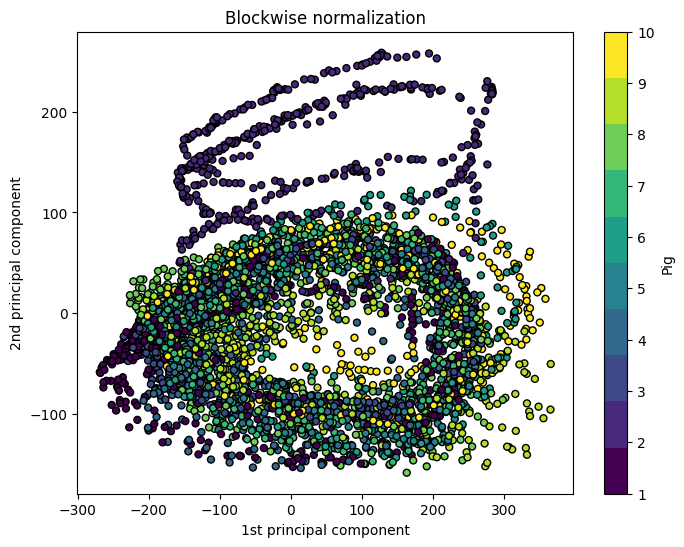

In [11]:
pigs_int = [int(c[0][4:6]) for c in clrs_pig_valid]

cmap = plt.get_cmap("viridis", np.max(pigs_int) - np.min(pigs_int) + 1)

plt.figure(figsize=(8, 6))
plt.title("Blockwise normalization")
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1], c=pigs_int, cmap=cmap, edgecolor="k", s=25
)

c_bar = plt.colorbar(scatter, ticks=np.arange(np.min(pigs_int), np.max(pigs_int) + 1))
c_bar.set_label("Pig")
c_bar.set_ticks(np.arange(np.min(pigs_int), np.max(pigs_int) + 1))

plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.show()

## Hyperparameter Tuning 

- [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)

In [12]:
import keras_tuner as kt
from tensorflow import keras

In [13]:
def build_model(hp):
    output_dim = 3

    model = keras.Sequential()
    # input layer
    model.add(keras.layers.Input(shape=(64, 1024, 1)))

    # tune the number of hidden layers and units in each.
    for i in range(1, hp.Int("num_layers", 3, 7)):
        print(f"Init layer {i=}")
        hp_units = hp.Int("units_" + str(i), min_value=2, max_value=16, step=4)
        hp_kernel = hp.Int("kernel_" + str(i), min_value=2, max_value=14, step=1)
        # stride dim (0,1)
        hp_strides_0 = hp.Int("units_0_" + str(i), min_value=1, max_value=4, step=1)
        hp_strides_1 = hp.Int("units_1_" + str(i), min_value=2, max_value=4, step=1)
        hp_activation = hp.Choice(
            "activation_" + str(i), values=["relu", "elu", "tanh"]
        )
        hp_dropout = hp.Float("dropout_" + str(i), 0, 1.0, step=0.1)

        # create layer
        model.add(
            keras.layers.Conv2D(
                hp_units,
                hp_kernel,
                strides=(hp_strides_0, hp_strides_1),
                padding="same",
            )
        )
        model.add(keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(hp_activation))
        model.add(keras.layers.Dropout(hp_dropout))

    model.add(keras.layers.Flatten())

    # for i in range(1, hp.Int("num_layers", 1, 4)):
    #    hp_units_dense = hp.Int("units_" + str(i), min_value=2**5, max_value=2**12, step=2**8)
    #    hp_activation_dense = hp.Choice("activation_" + str(i), values=['relu','elu','tanh'])
    #    model.add(keras.layers.Dense(hp_units_dense, activation=hp_activation_dense))

    # output layer.
    model.add(keras.layers.Dense(output_dim, activation="linear"))

    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.MeanAbsoluteError(),
        # loss=keras.losses.MeanSquaredError(),
        metrics=["accuracy"],
    )
    print(model.summary())

    return model

In [14]:
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    directory="mapper_tuning_v5",
    project_name="mapper_tuning_30db",
)

Init layer i=1
Init layer i=2


2024-12-19 14:00:33.896041: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0a:00.0, compute capability: 8.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 512, 2)     │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 512, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 512, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 512, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 256, 2)     │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 256, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 256, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 256, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │        98,307 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,351 (384.18 KB)

 Trainable params: 98,343 (384.15 KB)

 Non-trainable params: 8 (32.00 B)

None


**Tune model on full data**

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6)
tuner.search(
    X_train,
    y_train,
    epochs=50,
    batch_size=10,
    validation_data=(X_valid, y_valid),
    callbacks=[stop_early],
)

Trial 45 Complete [00h 02m 29s]
val_accuracy: 0.5885999798774719

Best val_accuracy So Far: 0.6358000040054321
Total elapsed time: 02h 07m 52s

Search: Running Trial #46

Value             |Best Value So Far |Hyperparameter
6                 |4                 |num_layers
2                 |6                 |units_1
9                 |3                 |kernel_1
1                 |1                 |units_0_1
3                 |2                 |units_1_1
relu              |elu               |activation_1
0.1               |0.3               |dropout_1
2                 |2                 |units_2
2                 |10                |kernel_2
3                 |2                 |units_0_2
4                 |4                 |units_1_2
relu              |tanh              |activation_2
0                 |0.9               |dropout_2
0.01              |0.001             |learning_rate
6                 |14                |units_3
2                 |14                |kernel_3
1     

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 342, 2)     │           164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 342, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 342, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 342, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 86, 2)      │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 86, 2)      │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 22, 86, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 86, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 43, 6)      │            54 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 22, 43, 6)      │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 22, 43, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 43, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 11, 2)       │           302 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 11, 2)       │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 11, 2)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 11, 2)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 3, 6)        │         1,206 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 3, 6)        │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 2, 3, 6)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 3, 6)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           111 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,927 (7.53 KB)

 Trainable params: 1,891 (7.39 KB)

 Non-trainable params: 36 (144.00 B)

None
Epoch 3/4
14500/14500 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5254 - loss: 0.0734 - val_accuracy: 0.2074 - val_loss: 0.0735
Epoch 4/4
11560/14500 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5302 - loss: 0.0724

**Train the model with the parameters from the hpt on the first nine pigs**

In [ ]:
m_idx = 30

In [ ]:
pigs = ["P_{0:02d}_PulHyp".format(i) for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]]  # exclude 10
print(pigs)

# load_path = "/data/PulHypStudie_Check_npz_v5_SNR20/"
X_expt10, y_expt10, clrs_pig_expt10 = load_augmented_example(
    load_path, pigs, sample_skip=500, load_samples="upwards", shuffle=True
)
X_valid_expt10, y_valid_expt10, clrs_pig_valid_expt10 = load_augmented_example(
    load_path, pigs, sample_skip=500, load_samples="downwards", shuffle=True
)

In [ ]:
np.max(y_expt10, axis=0), np.max(y_valid_expt10, axis=0)

In [ ]:
dap_factor = 120
sap_factor = 180
map_factor = 150

y_expt10[:, 0] = y_expt10[:, 0] / dap_factor  # dap normalization
y_expt10[:, 1] = y_expt10[:, 1] / sap_factor  # sap normalization
y_expt10[:, 2] = y_expt10[:, 2] / map_factor  # map normalization

y_valid_expt10[:, 0] = y_valid_expt10[:, 0] / dap_factor  # dap normalization
y_valid_expt10[:, 1] = y_valid_expt10[:, 1] / sap_factor  # sap normalization
y_valid_expt10[:, 2] = y_valid_expt10[:, 2] / map_factor  # map normalization

In [ ]:
np.max(y_expt10, axis=0), np.max(y_valid_expt10, axis=0)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
model = tuner.hypermodel.build(best_hps)

In [ ]:
best_hps.values

In [ ]:
history = model.fit(
    X_expt10,
    y_expt10,
    epochs=50,
    batch_size=8,
    validation_data=(X_valid_expt10, y_valid_expt10),
)

In [ ]:
model.save_weights(f"src/weights_v5/mapper_model_{m_idx}.weights.h5")

In [ ]:
# model.load_weights("src/weights_v3/mapper_model_2.weights.h5")

**Test model performance with trained model**

In [ ]:
pig_test_s_dict = {
    "P_01_PulHyp": 10338,
    "P_02_PulHyp": 12859,
    "P_03_PulHyp": 8124,
    "P_04_PulHyp": 8914,
    "P_05_PulHyp": 10063,
    "P_06_PulHyp": 6934,
    "P_07_PulHyp": 5692,
    "P_08_PulHyp": 7189,
    "P_09_PulHyp": 8228,
    "P_10_PulHyp": 6552,
}

# load pig 10 as the test pig
pigs_test = ["P_10_PulHyp"]
sample_skip = pig_test_s_dict[pigs_test[0]]
print(f"{sample_skip=}")

X_10, y_10, clrs_pig_10 = load_augmented_example(
    load_path,
    pigs_test,
    sample_skip=sample_skip,
    load_samples="downwards",
    shuffle=False,
)

In [ ]:
# predict EIT data of pig 10
y_pred = model.predict(X_10)

Y_true = y_10

Y_pred = np.empty(y_pred.shape)
Y_pred[:, 0] = y_pred[:, 0] * dap_factor  # dap normalization
Y_pred[:, 1] = y_pred[:, 1] * sap_factor  # sap normalization
Y_pred[:, 2] = y_pred[:, 2] * map_factor  # map normalization

In [ ]:
np.savez(
    f"src/weights_v5/result_mapper_{m_idx}.npz",
    Y_true=Y_true,
    Y_pred=Y_pred,
)

**Error estimation**

In [40]:
import pandas as pd
import seaborn as sns

In [41]:
DAP_err = Y_pred[:, 0] - Y_true[:, 0]
SAP_err = Y_pred[:, 1] - Y_true[:, 1]
MAP_err = Y_pred[:, 2] - Y_true[:, 2]

In [42]:
DF_err = pd.DataFrame({"DAP": DAP_err, "SAP": SAP_err, "MAP": MAP_err})
DF_err.to_csv(f"src/results/mapper_{m_idx}.csv", index=False)

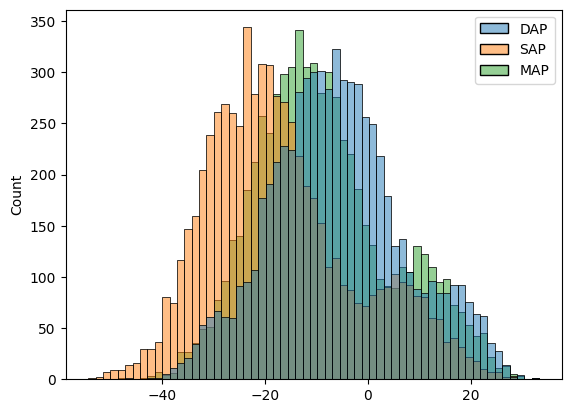

In [43]:
sns.histplot(DF_err)
plt.savefig(f"src/results/histplot_{m_idx}.png")

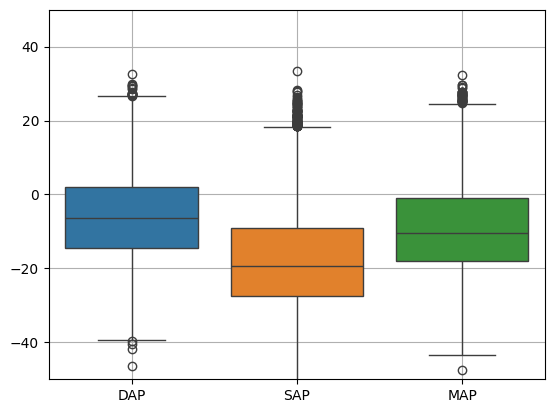

In [44]:
sns.boxplot(DF_err)
plt.grid()
plt.ylim([-50, 50])
plt.savefig(f"src/results/boxplot_{m_idx}.png")

In [45]:
model.loss(Y_true, Y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=14.966791>

In [46]:
model.loss(Y_true, Y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=14.966791>

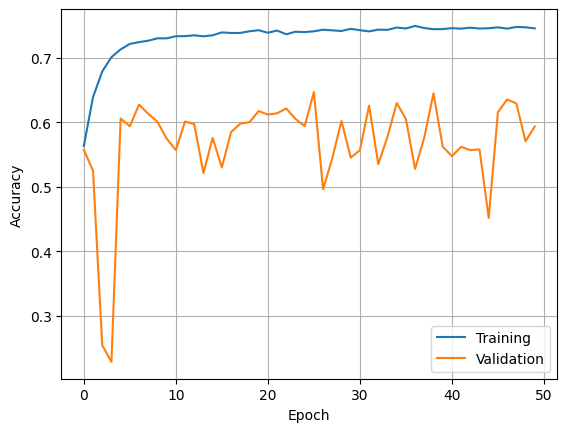

In [47]:
plt.plot(history.history["accuracy"], label="Training")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.grid()
# plt.ylim([0,1.])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig(f"src/results/accrcy_{m_idx}.png")
plt.show()

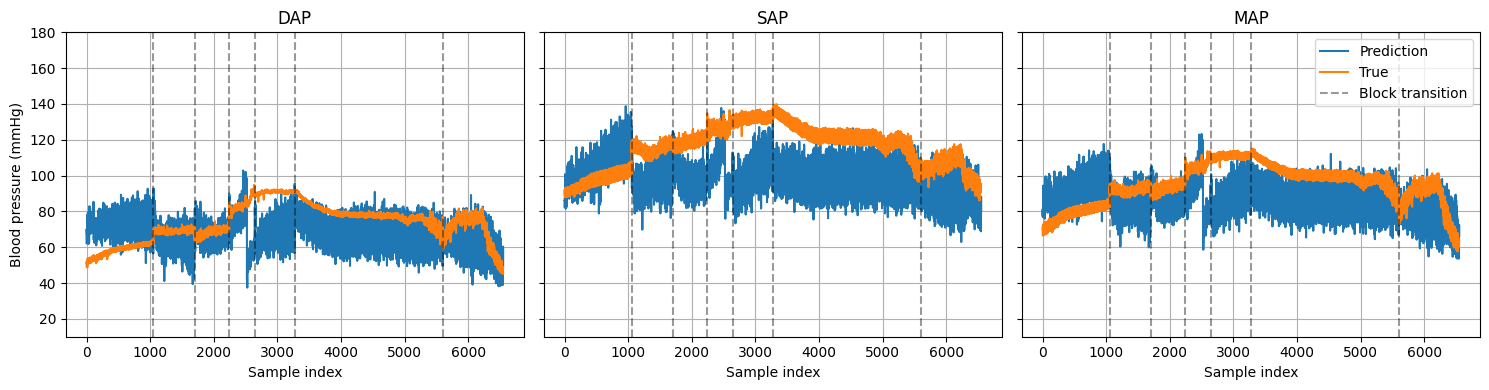

In [48]:
ttl = ["DAP", "SAP", "MAP"]
block_list = [int(bl.split("_")[1]) for bl in clrs_pig_10[:, 1]]
change_indices = np.where(np.diff(block_list) != 0)[0] + 1
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, ax in enumerate(axes):
    ax.set_title(ttl[i])
    ax.plot(Y_pred[:, i], label="Prediction")
    ax.plot(Y_true[:, i], label="True")
    ax.set_ylim([10, 180])
    for idx, vline in enumerate(change_indices):
        if idx == 0:
            ax.axvline(
                vline,
                color="black",
                linestyle="--",
                alpha=0.4,
                label="Block transition",
            )
        else:
            ax.axvline(vline, color="black", linestyle="--", alpha=0.4)
    ax.grid()
    ax.set_xlabel("Sample index")
    if i == 0:
        ax.set_ylabel("Blood pressure (mmHg)")

plt.legend()
plt.tight_layout()
# plt.savefig(f"dap_sap_map_test_pig_0{PIG}.png", dpi=900)
plt.show()

In [49]:
from scipy.signal import butter, filtfilt


def lowpass_filter(data, cutoff=10, fs=1000, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

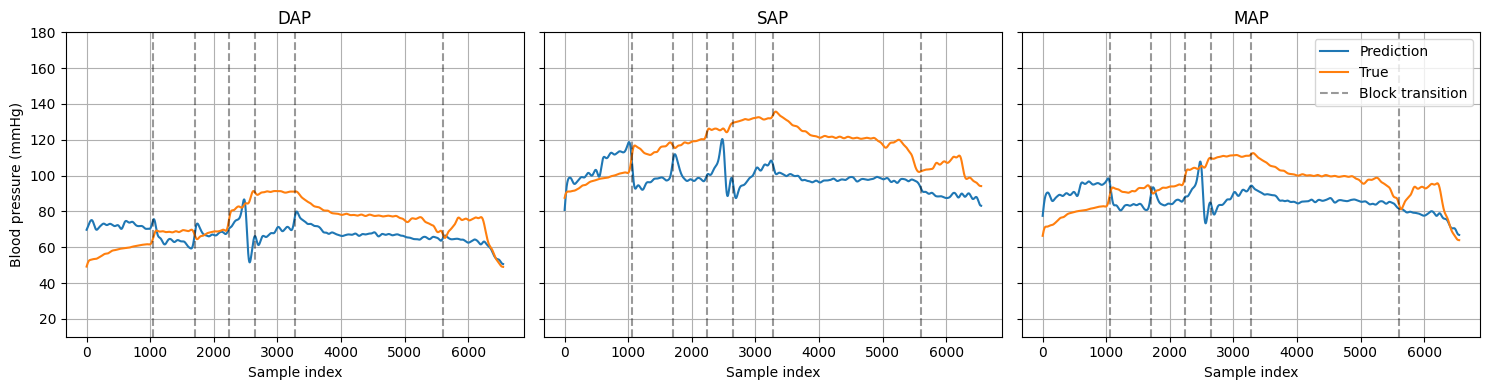

In [50]:
ttl = ["DAP", "SAP", "MAP"]
block_list = [int(bl.split("_")[1]) for bl in clrs_pig_10[:, 1]]
change_indices = np.where(np.diff(block_list) != 0)[0] + 1
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, ax in enumerate(axes):
    ax.set_title(ttl[i])
    ax.plot(lowpass_filter(Y_pred[:, i]), label="Prediction")
    ax.plot(lowpass_filter(Y_true[:, i]), label="True")
    ax.set_ylim([10, 180])
    for idx, vline in enumerate(change_indices):
        if idx == 0:
            ax.axvline(
                vline,
                color="black",
                linestyle="--",
                alpha=0.4,
                label="Block transition",
            )
        else:
            ax.axvline(vline, color="black", linestyle="--", alpha=0.4)
    ax.grid()
    ax.set_xlabel("Sample index")
    if i == 0:
        ax.set_ylabel("Blood pressure (mmHg)")

plt.legend()
plt.tight_layout()
# plt.savefig(f"dap_sap_map_test_pig_0{PIG}.png", dpi=900)
plt.show()

___

## Export

**export results**

In [ ]:
from plotLaTeX import HistPlot, BoxPlot

In [ ]:
hist = HistPlot(bins=25)

In [ ]:
hist.add_histdata(DAP_err, "DAP")
hist.add_histdata(SAP_err, "SAP")
hist.add_histdata(MAP_err, "MAP")

In [ ]:
hist.add_axis_labels(xlabel="Absolute AP deviation (mmHg)", ylabel="Count")

In [ ]:
hist.export(f_name="hist_results.csv")

In [ ]:
box = BoxPlot()

In [ ]:
box.add_data(DAP_err, "DAP")
box.add_data(SAP_err, "SAP")
box.add_data(MAP_err, "MAP")

In [ ]:
box.add_axis_labels(xlabel="AP", ylabel="Absolute Error (mmHg)")

In [ ]:
box.LaTeXcode()

In [ ]:
DAP_rerr = (Y_pred[:, 0] - Y_true[:, 0]) / Y_true[:, 0] * 100
SAP_rerr = (Y_pred[:, 1] - Y_true[:, 1]) / Y_true[:, 1] * 100
MAP_rerr = (Y_pred[:, 2] - Y_true[:, 2]) / Y_true[:, 2] * 100

In [ ]:
box_r = BoxPlot()

In [ ]:
box_r.add_data(DAP_rerr, "DAP")
box_r.add_data(SAP_rerr, "SAP")
box_r.add_data(MAP_rerr, "MAP")

In [ ]:
box_r.add_axis_labels(xlabel="AP", ylabel="Relative Error")

In [ ]:
box_r.LaTeXcode()

In [ ]:
DF_rerr = pd.DataFrame({"DAP": DAP_rerr, "SAP": SAP_rerr, "MAP": MAP_rerr})

In [ ]:
sns.boxplot(DF_rerr)
plt.grid()
plt.ylim([-50, 50])

In [ ]:
df = DF_rerr

summary = {}
for column in df.columns:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    median = df[column].median()
    iqr = q3 - q1  # Interquartilsabstand
    lower_whisker = df[column][df[column] >= (q1 - 1.5 * iqr)].min()
    upper_whisker = df[column][df[column] <= (q3 + 1.5 * iqr)].max()

    summary[column] = {
        "Q1": q1,
        "Median": median,
        "Q3": q3,
        "Lower Whisker": lower_whisker,
        "Upper Whisker": upper_whisker,
    }

summary_df = pd.DataFrame(summary).T
print(summary_df)